# Can overconfidence be eliminated by reserving a portion of the training data to only be optimized for the distribution parameters $\sigma$ and $\alpha$, and unseen by $\mu$?
Specifically, train everything on a large portion of the training data, then forecast the mean of the unseen training data, and train the skewness and variance on that portion.

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy.stats import norm, skewnorm, skew

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import *
from model_objs import *
import vanilla_benchmark

## Pinball Loss

In [4]:
def skew_pinball_loss(data, mus, sigmas, alphas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = skewnorm.ppf(q, alphas[i], loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [5]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

## Vanilla Benchmark Forecast

In [6]:
min_train_start = 9 * 365 * 24 + 2 * 24  # 2 leap years in from 2005 to 2014
train_starts = np.linspace(min_train_start, min_train_start + 24 * 365 - 24, 12, endpoint=False).astype(int)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [7]:
print(list(train_starts))

[78888, 79616, 80344, 81072, 81800, 82528, 83256, 83984, 84712, 85440, 86168, 86896]


In [8]:
zone_name = "ISONE CA"

In [9]:
vanilla_losses = [397.54593426786477, 604.6018135096928, 329.1556644285198, 197.8631423987858, 323.53210964925717, 415.8909833353536, 544.7284618154562, 540.057213205938, 570.237691916539, 181.8698616921875, 262.12280478463936, 471.97246124553413]
# vanilla_losses = []
# for month in range(1, len(months) + 1):
#     print(months[month-1])
#     vanilla_losses.append(vanilla_benchmark.get_lossesGEFCom(10, 31 * 24, start_date=pd.Timestamp(f"2005-{month}-01"), zones=["ISONE CA"],
#                               delay_days=0, temp_years=np.arange(2005, 2015), plot=True)["ISONE CA"])

In [10]:
for i, loss in list(enumerate(vanilla_losses))[::2]:
    print(np.round(loss, 1), end="\t")

397.5	329.2	323.5	544.7	570.2	262.1	

In [11]:
import json

with open("GEFCom2017\\GEFCom2017-Qual\\GEFCom2017Qual2005-2015.json") as f:
    all_data = json.loads(f.read())
    
data = np.transpose(np.array([all_data[zone_name]["DEMAND"]], dtype=np.float64))

In [12]:
# rescale data
x_original = data
mean = np.mean(data, axis=0)
rnge = np.max(data, axis=0) - np.min(data, axis=0)
data = (data - np.matlib.repmat(mean, data.shape[0], 1)) / np.matlib.repmat(rnge, data.shape[0], 1)
print("data", data.shape)

data (96408, 1)


# Forecasting mean, variance, and skewness of Skew-Normal distribution

In [13]:
%matplotlib inline
z_scores = []
test_z_scores = []
losses = []
relative_perfs = []

TRAIN START: 78888 = 2014-01-01 00:00:00
x (9504, 1)
xt (8760, 1)
Loss at iteration 10: 1.704802057558942
Loss at iteration 60: -1.399573030684537
Loss at iteration 110: -1.881065680700619
Loss at iteration 160: -1.9851699930451518
Loss at iteration 210: -2.033537932780065
Loss at iteration 260: -2.065658637333161
Loss at iteration 310: -2.1000257712541743
Loss at iteration 360: -2.1273378756934034
Loss at iteration 410: -2.151374609331084
Loss at iteration 460: -2.1811538141543805
Loss at iteration 510: -2.1955306905342553
Loss at iteration 560: -2.2160874727928146
Final loss: -2.237155593991467


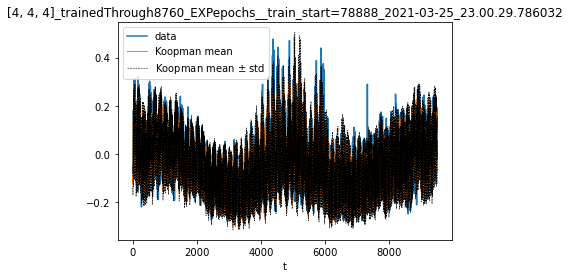

actual overall mean: 0  predicted mean: -0.017357843


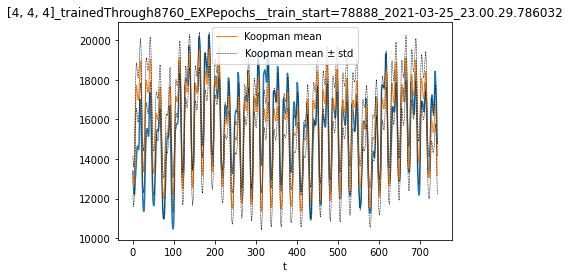

pinball_loss: 334.5064221903896
15.857164328336303% performance relative to vanilla benchmark





TRAIN START: 80344 = 2014-03-02 00:00:00
x (9504, 1)
xt (8760, 1)
Loss at iteration 10: 1.5797249723129227
Loss at iteration 60: -1.4680139513175368
Loss at iteration 110: -1.9731072320433634
Loss at iteration 160: -2.0582170136294864
Loss at iteration 210: -2.107847896123022
Loss at iteration 260: -2.1452499234469826
Loss at iteration 310: -2.1761667604466113
Loss at iteration 360: -2.2102595112969157
Loss at iteration 410: -2.2375568704390494
Loss at iteration 460: -2.278539847719959
Loss at iteration 510: -2.3105361621114278
Loss at iteration 560: -2.337538453655036
Final loss: -2.3513435855883396


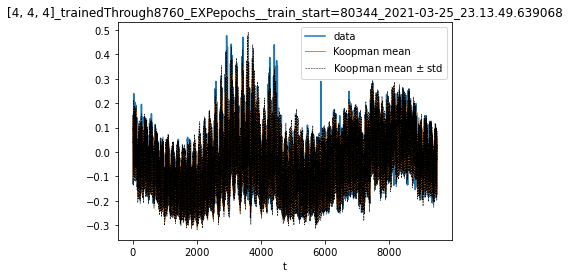

actual overall mean: 0  predicted mean: -0.015072249


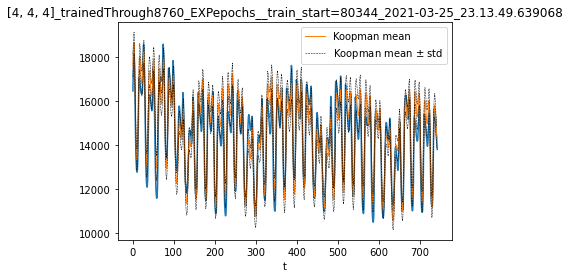

pinball_loss: 203.73494640644685
38.103770214566545% performance relative to vanilla benchmark





TRAIN START: 81800 = 2014-05-02 00:00:00
x (9504, 1)
xt (8760, 1)
Loss at iteration 10: 1.9756109955652466
Loss at iteration 60: -1.3300598388985523
Loss at iteration 110: -1.9228038116167807
Loss at iteration 160: -2.0294797913308966
Loss at iteration 210: -2.0945234319941823
Loss at iteration 260: -2.131238527913021
Loss at iteration 310: -2.1671897103402795
Loss at iteration 360: -2.202742801756144
Loss at iteration 410: -2.2364313450834636
Loss at iteration 460: -2.2583613255837913
Loss at iteration 510: -2.288854827464717
Loss at iteration 560: -2.31891494309698
Final loss: -2.3411386605072106


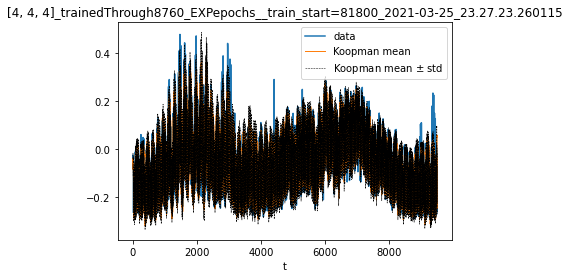

actual overall mean: 0  predicted mean: -0.01744134


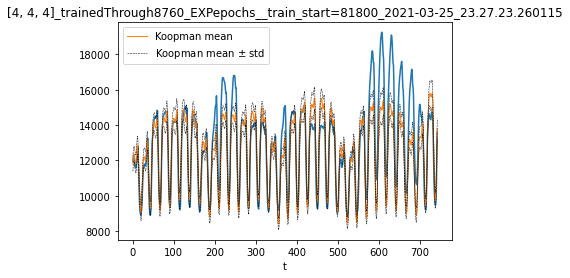

pinball_loss: 364.0798459836028
-12.532832174928066% performance relative to vanilla benchmark





TRAIN START: 83256 = 2014-07-02 00:00:00
x (9504, 1)
xt (8760, 1)
Loss at iteration 10: 1.8015218799675263
Loss at iteration 60: -1.383012195815831
Loss at iteration 110: -1.8589221429616771
Loss at iteration 160: -1.968053349192122
Loss at iteration 210: -2.0143485676363215
Loss at iteration 260: -2.043394475149231
Loss at iteration 310: -2.0671410819638454
Loss at iteration 360: -2.0938053097260347
Loss at iteration 410: -2.1111098926136975
Loss at iteration 460: -2.1341914870795837
Loss at iteration 510: -2.154776065334802
Loss at iteration 560: -2.1747333905749175
Final loss: -2.2004284904412086


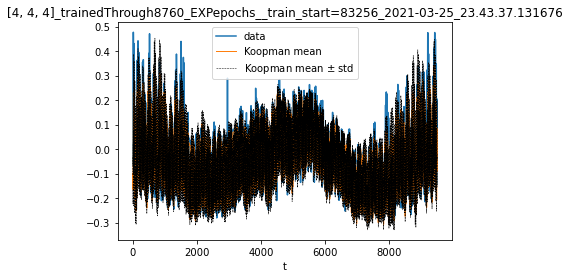

actual overall mean: 0  predicted mean: -0.018299568


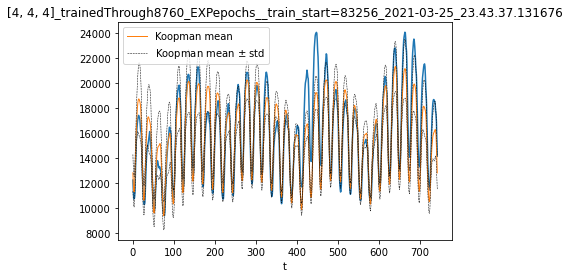

pinball_loss: 428.4206071985964
21.351528838649656% performance relative to vanilla benchmark





TRAIN START: 84712 = 2014-08-31 00:00:00
x (9504, 1)
xt (8760, 1)
Loss at iteration 10: 1.6361040958122677
Loss at iteration 60: -1.273746134416223
Loss at iteration 110: -1.751955064614918
Loss at iteration 160: -1.864898828644886
Loss at iteration 210: -1.9333196289879233
Loss at iteration 260: -1.99994485868363
Loss at iteration 310: -2.0422576417179976
Loss at iteration 360: -2.070099522532096
Loss at iteration 410: -2.0912297398087385
Loss at iteration 460: -2.1153946237100816
Loss at iteration 510: -2.1329102962831765
Loss at iteration 560: -2.153267039513244
Final loss: -2.162561770674592


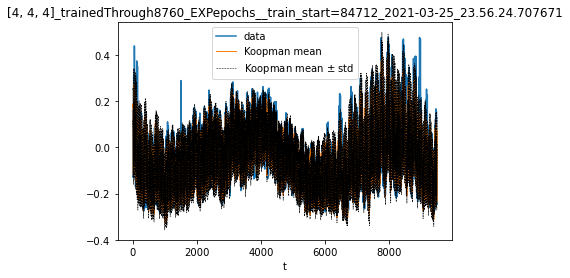

actual overall mean: 0  predicted mean: -0.011335393


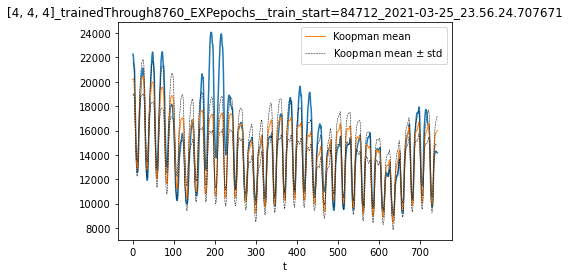

pinball_loss: 456.0589137490183
20.0230149262445% performance relative to vanilla benchmark





TRAIN START: 86168 = 2014-10-31 00:00:00
x (9504, 1)
xt (8760, 1)
Loss at iteration 10: 1.4544686022951636
Loss at iteration 60: -1.3695115687730328
Loss at iteration 110: -1.8303060024946403
Loss at iteration 160: -1.90079905058755
Loss at iteration 210: -1.9645355394689894
Loss at iteration 260: -2.0146625631203148
Loss at iteration 310: -2.0448275700833225
Loss at iteration 360: -2.073790120988476
Loss at iteration 410: -2.1078330040222237
Loss at iteration 460: -2.1342230549820163
Loss at iteration 510: -2.1670180948798365
Loss at iteration 560: -2.195661211358331
Final loss: -2.2284170989436287


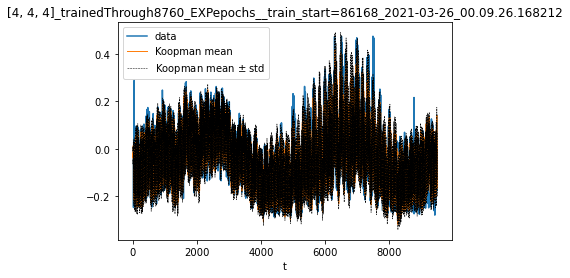

actual overall mean: 0  predicted mean: -0.009782841


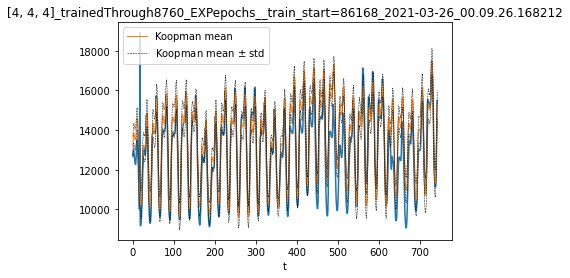

pinball_loss: 306.3698405983961
-16.880269479074972% performance relative to vanilla benchmark







In [14]:
for month, train_start in list(enumerate(train_starts))[::2]:
    print("TRAIN START:", train_start, "=", all_data[zone_name]["Date"][train_start])
    
    train_through = 365 * 24
    delay = 0  # 52 * 24
    predict_through = train_through + 24 * 31 + delay  
    x = data[train_start:]
    x = x[:predict_through]
    xt = x[:train_through]
    num_freqs = [4, 4, 4]
    num_fourier = 4
    loss_weights = 1 + 0.4 * torch.cos(torch.linspace(0, 2 * np.pi, xt.shape[0]))
    print("x", x.shape)
    print("xt", xt.shape)
    
    now = ("_".join(str(datetime.now()).split())).replace(":", ".")
    data_name = "EXPepochs_" + f"_train_start={train_start}_" + now

    ### TRAIN ###
    model = AlternatingSkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
    k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)
    
    k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.24])
    
    k.fit(xt, iterations=600, verbose=False, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

    fname = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}"
    mu_file = fname + "mu.npy"
    sigma_file = fname + "sigma.npy"
    alpha_file = fname + "alpha.npy"    

    ### FORECAST ###
    params = k.predict(predict_through)
    mu_hat, sigma_hat, a_hat = params
    
    mean_hat = model.mean(params)
    std_hat = model.std(params)
    
    # ADD TO CORRECT BIAS                                                    
    adjust = np.mean((xt - mean_hat[:train_through]) / std_hat[:train_through]) / (np.mean(1 / std_hat[:train_through]))
    mu_hat += adjust
    np.save(mu_file, mu_hat)
    np.save(sigma_file, sigma_hat)
    np.save(alpha_file, a_hat)

    mean_hat = model.mean(params)
    std_hat = model.std(params)

    dim = 0
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    #plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    #plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    ### ANALYTICS ###
    print("actual overall mean:", 0, " predicted mean:", np.mean(mean_hat[:train_through]))

    z_scores.append((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
    test_z_scores.append(
        (x[train_through + delay:predict_through] - mean_hat[train_through + delay:predict_through]) 
         / std_hat[train_through + delay:predict_through])

    ### PERFORMANCE ###

    #Skew-Normal distribution Rescaling to de-normalize data because pinball loss is not scale-invariant
    test_start = train_through + delay
    sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
    delta = ah / (1 + ah ** 2) ** 0.5
    muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    muh = muh + mean - (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    sigh = sigh * rnge
    mean_hat = model.mean([muh, sigh, ah])
    std_hat = model.std([muh, sigh, ah])

    plt.figure()
    plt.plot(x_original[train_start:][test_start: predict_through])
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    # plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    # plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    loss = skew_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh, ah)[0]
    relative = (1 - loss/vanilla_losses[month]) * 100
    print("pinball_loss:", loss)
    print(f"{relative}% performance relative to vanilla benchmark" + "\n"*5)
    losses.append(loss)
    relative_perfs.append(relative)

# Figures

In [15]:
# for tables
for loss in losses[:6]:
    print(np.round(loss, 1), end="\t")
print("")
for rel in relative_perfs[:6]:
    print(np.round(rel, 1), end="%\t")

334.5	203.7	364.1	428.4	456.1	306.4	
15.9%	38.1%	-12.5%	21.4%	20.0%	-16.9%	

In [16]:
idx = 6
for z_score in z_scores[:idx]:
    print(np.round(np.mean(z_score), 2), end="\t")
print()
for z_score in z_scores[:idx]:
    print(np.round(np.std(z_score), 2), end="\t")
print()
for z_score in z_scores[:idx]:
    print(np.round(skew(z_score)[0], 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(np.mean(z_score), 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(np.std(z_score), 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(skew(z_score)[0], 2), end="\t")

0.0	0.0	-0.0	0.0	0.0	0.0	
0.99	0.97	0.98	1.0	0.97	0.99	
0.46	0.32	0.45	0.6	0.49	0.55	
-0.06	-0.32	0.83	0.36	0.59	-1.11	
1.11	1.19	2.19	1.41	1.59	1.59	
-0.0	0.07	0.68	1.38	1.14	0.02	

In [202]:
z_scores = np.array(z_scores)
test_z_scores = np.array(test_z_scores)
losses = np.array(losses)
relative = np.array(relative_perfs)

In [203]:
np.save("experiments\\" + data_name + "z_scores.npy", z_scores)
np.save("experiments\\" + data_name + "test_z_scores.npy", test_z_scores)
np.save("experiments\\" + data_name + "relative_perfs.npy", relative_perfs)
np.save("experiments\\" + data_name + "losses.npy", losses)

In [208]:
import os
%matplotlib inline
z_scores = []
test_z_scores = []
losses = []
relative_perfs = []

TRAIN START: 84712 = 2014-08-31 00:00:00
x (9504, 1)
xt (8760, 1)
EXPepochs__train_start=84712_2021-03-24_00.53.01.507331trained84712-8760_[4, 4, 4]alpha.npy
EXPepochs__train_start=84712_2021-03-24_00.53.01.507331trained84712-8760_[4, 4, 4]mu.npy
EXPepochs__train_start=84712_2021-03-24_00.53.01.507331trained84712-8760_[4, 4, 4]sigma.npy


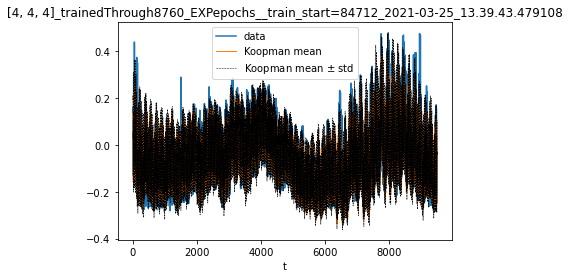

predicted mean: -0.013006175  actual: -0.012378204485746567
bias train: 7.272471678543838e-09 bias test: 0.42876440084031203


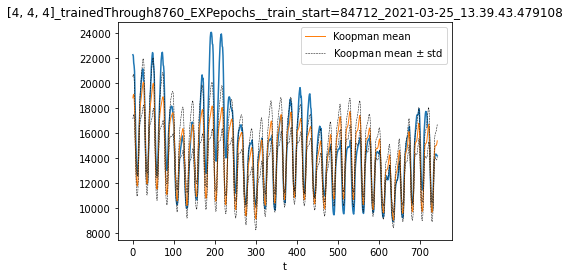

pinball_loss: 492.95214429498424
13.553216267027546% performance relative to vanilla benchmark







In [210]:
path = "C:\\Users\\ATMal\\PycharmProjects\\koopman-forecasting\\forecasts\\experiment10"
for month, train_start in list(enumerate(train_starts))[::2][4:5]:
    print("TRAIN START:", train_start, "=", all_data[zone_name]["Date"][train_start])
    
    train_through = 365 * 24
    delay = 0  # 52 * 24
    predict_through = train_through + 24 * 31 + delay  
    x = data[train_start:]
    x = x[:predict_through]
    xt = x[:train_through]
    num_freqs = [4, 4, 4]
    num_fourier = 4
    loss_weights = 1 + 0.4 * torch.cos(torch.linspace(0, 2 * np.pi, xt.shape[0]))
    print("x", x.shape)
    print("xt", xt.shape)
    
    now = ("_".join(str(datetime.now()).split())).replace(":", ".")
    data_name = "EXPepochs_" + f"_train_start={train_start}_" + now

    ### TRAIN ###
    model = AlternatingSkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
    
    ### GET OLD DATA
    for fname in os.listdir(path):
        if fname.startswith(f"EXPepochs__train_start={train_start}"):
            print(fname)
            if fname.endswith("alpha.npy"):
                a_hat = np.load(os.path.join(path, fname))
            if fname.endswith("sigma.npy"):
                sigma_hat = np.load(os.path.join(path, fname))
            if fname.endswith("mu.npy"):
                mu_hat = np.load(os.path.join(path, fname))
    params = (mu_hat, sigma_hat, a_hat)
    
    fname = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}"
    mu_file = fname + "mu.npy"
    sigma_file = fname + "sigma.npy"
    alpha_file = fname + "alpha.npy"
    
    mean_hat = model.mean(params)
    std_hat = model.std(params)
    
    adjust = np.mean((xt - mean_hat[:train_through]) / std_hat[:train_through]) / (np.mean(1 / std_hat[:train_through]))
    mu_hat += adjust                                                     # <<< CHANGE THIS LINE TO EXPERIMENT
#     mu_hat += xt[-1] - mean_hat[train_through - 1]
    np.save(mu_file, mu_hat)
    np.save(sigma_file, sigma_hat)
    np.save(alpha_file, a_hat)

    mean_hat = model.mean(params)
    std_hat = model.std(params)

    dim = 0
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    #plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    #plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    ### ANALYTICS ###
    print("predicted mean:", np.mean(mean_hat[:train_through]), " actual:", np.mean(xt))

    z_scores.append((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
    test_z_scores.append(
        (x[train_through + delay:predict_through] - mean_hat[train_through + delay:predict_through]) 
         / std_hat[train_through + delay:predict_through])
    print("bias train:", np.mean(z_scores[-1]), "bias test:", np.mean(test_z_scores[-1]))

    ### PERFORMANCE ###

    #Skew-Normal distribution Rescaling to de-normalize data because pinball loss is not scale-invariant
    test_start = train_through + delay
    sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
    delta = ah / (1 + ah ** 2) ** 0.5
    muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    muh = muh + mean - (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    sigh = sigh * rnge
    mean_hat = model.mean([muh, sigh, ah])
    std_hat = model.std([muh, sigh, ah])

    plt.figure()
    plt.plot(x_original[train_start:][test_start: predict_through])
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    # plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    # plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    loss = skew_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh, ah)[0]
    relative = (1 - loss/vanilla_losses[month]) * 100
    print("pinball_loss:", loss)
    print(f"{relative}% performance relative to vanilla benchmark" + "\n"*5)
    losses.append(loss)
    relative_perfs.append(relative)

Text(0, 0.5, 'standardized residual $z$')

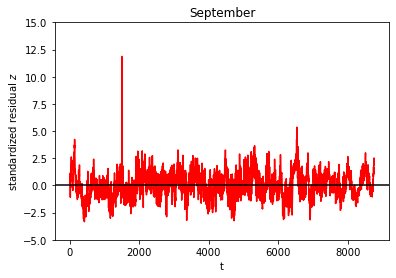

In [211]:
plt.plot(z_scores[4], color="r")
plt.title("September")
plt.axhline(0, color="k")
plt.xlabel("t")
plt.ylim([-5, 15])
plt.ylabel("standardized residual $z$")

In [96]:
zs = (xt - mu_hat[:train_through]) / sigma_hat[:train_through]

In [97]:
b = np.mean(zs)

In [98]:
a = b / (np.mean(1 / sigma_hat[:train_through]))

In [99]:
a

0.03618646150443811

In [100]:
zsc = (xt - (mu_hat[:train_through] + a)) / sigma_hat[:train_through]

In [101]:
zsc.mean()

1.130180568147571e-07